# Aug ??, 2022 ()

**Motivation**:  <br>

In [1]:
# HIDE CODE


import os
import sys
from pprint import pprint
from copy import deepcopy as dc
from os.path import join as pjoin
from scipy.ndimage import gaussian_filter
from IPython.display import display, IFrame, HTML

# tmp & extras dir
git_dir = pjoin(os.environ['HOME'], 'Dropbox/git')
extras_dir = pjoin(git_dir, 'jb-Ca-fMRI/_extras')
fig_base_dir = pjoin(git_dir, 'jb-Ca-fMRI/figs')
tmp_dir = pjoin(git_dir, 'jb-Ca-fMRI/tmp')

# GitHub
sys.path.insert(0, pjoin(git_dir, '_Ca-fMRI'))
from figures.fighelper import *
from analysis.final import *
from utils.render import *

# warnings, tqdm, & style
warnings.filterwarnings('ignore', category=DeprecationWarning)
from tqdm.notebook import tqdm
%matplotlib inline
set_style()

In [2]:
nn = 512
mice = Mice(nn, full_load=True, load_parcel=True, load_allen=True)

ROI lookup not found, time to run organize_func() . . .

combine metadata not found, time to run cat_data() . . .

In [3]:
from register.register import Register

reg = Register(mice)
tsnr_masks = reg.get_tsnr_masks(q_bold=0.05)

Name: cortex . . . a total of: 540 regions accepted, 174 regions rejected.
accept ratio: 75.63 %, reject ratio: 24.37 %, using a presence threshold of 20.0 %

In [4]:
reg.mode

'ca2'

In [12]:
tsnr_masks = tsnr_masks['ca2']

In [4]:
key = 'sub-SLC09_ses-2_run-1'
func = mice.ca_preproc[key]
x = func.load_ants().numpy()
x.shape

(256, 250, 1, 5999)

In [13]:
sub, ses, run = mice.looper[key]
_k = mice.get_key(sub, ses)
m_indiv = mice.mask2d[_k].load_ants()
m_indiv = m_indiv.numpy().astype(bool)
m_tsnr = tsnr_masks.get(key)
if m_tsnr is not None:
    m_indiv = np.logical_and(m_indiv, m_tsnr)

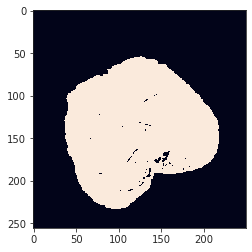

In [16]:
plt.imshow(m_indiv);

In [18]:
from register.preprocess import process_ca

In [19]:
_, xf, tmask, ab = process_ca(
    mice=mice,
    key=key,
    x=x,
    m=m_indiv,
    filt_std=5,
    filt_ab=True,
    fill_nuisance=False,
    band=[0.01, 0.5, (0.01, 0.5)],
)

In [23]:
m=m_indiv
filt_std=5
filt_ab=True
fill_nuisance=False

In [24]:
x = x[m].squeeze()
x.shape

(22230, 5999)

In [25]:
fs = mice.cfg.ca_fs
fs

10

In [21]:
xf[0.01].shape

(22230, 5500)

[<matplotlib.lines.Line2D object at 0x7feb63a16400>]

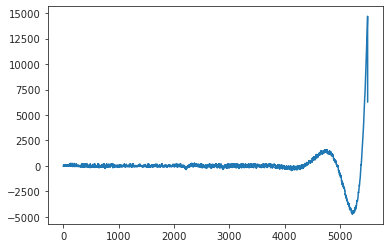

In [22]:
plt.plot(xf[0.01].mean(0))

In [27]:
gs = x.mean(0)
thres = gs.std() * filt_std
bad_t = np.abs(gs - gs.mean()) > thres

In [29]:
bad_t.sum()

11

[<matplotlib.lines.Line2D object at 0x7feb63981280>]

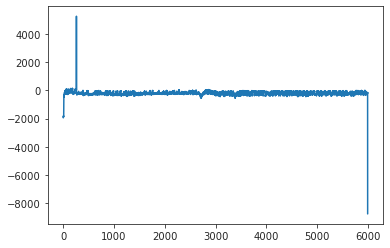

In [31]:
plt.plot(gs)

In [32]:
gs[bad_t]

array([-1902.2482, -1945.8721, -1856.7208, -1806.2798, -1844.0104,
       -1821.3132, -1859.4622, -1842.5814, -1839.6288,  5268.1714,
       -8773.177 ], dtype=float32)

In [34]:
np.where(bad_t)[0]

array([   0,    1,    2,    3,    4,    5,    6,    7,    8,  259, 5998])

## no_WM_CSF

In [38]:
pth = '/mnt/storage/hadi/Ca-fMRI/gabe_data/reoriented_data_no_WM_CSF/cleaned_timeseries'
for sub in range(1, 10 + 1):
    for ses in range(1, 3 + 1):
        key = f"sub-SLC{sub:02d}_ses-{ses}"
        files = sorted(filter(
            lambda x: key in x,
            os.listdir(pth),
        ))
        for f in files:
            name = '_'.join(f.split('_')[:4])
            name = f"{name}_space-individual_desc-rabies-nowmcsf_bold.nii.gz"
            filename = pjoin(mice.cfg.raw_dir, name)
            if not os.path.isfile(filename):
                shutil.copyfile(
                    src=pjoin(pth, f),
                    dst=filename,
                )
            else:
                print(f"File found, skipping:\n'{name}'\n")

In [39]:
pth = '/mnt/storage/hadi/Ca-fMRI/gabe_data/reoriented_data_no_WM_CSF'
csv_files = []
for p in pathlib.Path(pth).rglob('*.csv'):
    csv_files.append(str(p))
    
meta_dir = pjoin(mice.cfg.base_dir, 'meta_info')

dlist = []
for sub in range(1, 10 + 1):
    for ses in range(1, 3 + 1):
        for run in range(1, 7 + 1):
            patterns = [
                f"sub-SLC{sub:02d}",
                f"ses-{ses:d}",
                f"run-{run:d}",
            ]
            key = '_'.join(patterns)
            try:
                f = next(
                    e for e in csv_files if
                    all(k in e for k in patterns)
                )
                vals = pd.read_csv(f).values.ravel()
                dlist.append({
                    'sub': [sub] * len(vals),
                    'ses': [ses] * len(vals),
                    'run': [run] * len(vals),
                    'key': [key] * len(vals),
                    'temporal_mask': vals.astype(int),
                })
            except StopIteration:
                print(f"Warning, missing:\t{key}")

df = pd.DataFrame(merge_dicts(dlist))
_ = save_obj(
    obj=df,
    file_name='tmask_nowmcsf',
    save_dir=meta_dir,
    mode='df',
)

Warning, missing:       sub-SLC01_ses-1_run-4

Warning, missing:       sub-SLC03_ses-1_run-1

Warning, missing:       sub-SLC03_ses-3_run-2

Warning, missing:       sub-SLC04_ses-3_run-2

Warning, missing:       sub-SLC05_ses-1_run-5

Warning, missing:       sub-SLC06_ses-3_run-2

Warning, missing:       sub-SLC07_ses-1_run-6

Warning, missing:       sub-SLC07_ses-2_run-1

Warning, missing:       sub-SLC08_ses-1_run-7

Warning, missing:       sub-SLC10_ses-1_run-5

[PROGRESS] 'tmask_nowmcsf.df' saved at
/home/hadi/Documents/Ca-fMRI/meta_info

## no_CR

In [40]:
pth = '/mnt/storage/hadi/Ca-fMRI/gabe_data/reoriented_data_no_CR/cleaned_timeseries'
for sub in range(1, 10 + 1):
    for ses in range(1, 3 + 1):
        key = f"sub-SLC{sub:02d}_ses-{ses}"
        files = sorted(filter(
            lambda x: key in x,
            os.listdir(pth),
        ))
        for f in files:
            name = '_'.join(f.split('_')[:4])
            name = f"{name}_space-individual_desc-rabies-nocr_bold.nii.gz"
            filename = pjoin(mice.cfg.raw_dir, name)
            if not os.path.isfile(filename):
                shutil.copyfile(
                    src=pjoin(pth, f),
                    dst=filename,
                )
            else:
                print(f"File found, skipping:\n'{name}'\n")

In [41]:
pth = '/mnt/storage/hadi/Ca-fMRI/gabe_data/reoriented_data_no_CR'
csv_files = []
for p in pathlib.Path(pth).rglob('*.csv'):
    csv_files.append(str(p))
    
meta_dir = pjoin(mice.cfg.base_dir, 'meta_info')

dlist = []
for sub in range(1, 10 + 1):
    for ses in range(1, 3 + 1):
        for run in range(1, 7 + 1):
            patterns = [
                f"sub-SLC{sub:02d}",
                f"ses-{ses:d}",
                f"run-{run:d}",
            ]
            key = '_'.join(patterns)
            try:
                f = next(
                    e for e in csv_files if
                    all(k in e for k in patterns)
                )
                vals = pd.read_csv(f).values.ravel()
                dlist.append({
                    'sub': [sub] * len(vals),
                    'ses': [ses] * len(vals),
                    'run': [run] * len(vals),
                    'key': [key] * len(vals),
                    'temporal_mask': vals.astype(int),
                })
            except StopIteration:
                print(f"Warning, missing:\t{key}")

df = pd.DataFrame(merge_dicts(dlist))
_ = save_obj(
    obj=df,
    file_name='tmask_nocr',
    save_dir=meta_dir,
    mode='df',
)

Warning, missing:       sub-SLC01_ses-1_run-4

Warning, missing:       sub-SLC03_ses-1_run-1

Warning, missing:       sub-SLC03_ses-3_run-2

Warning, missing:       sub-SLC04_ses-3_run-2

Warning, missing:       sub-SLC05_ses-1_run-5

Warning, missing:       sub-SLC06_ses-3_run-2

Warning, missing:       sub-SLC07_ses-1_run-6

Warning, missing:       sub-SLC07_ses-2_run-1

Warning, missing:       sub-SLC08_ses-1_run-7

Warning, missing:       sub-SLC10_ses-1_run-5

[PROGRESS] 'tmask_nocr.df' saved at
/home/hadi/Documents/Ca-fMRI/meta_info

## Ca data copy again

In [45]:
pth = '/mnt/storage/hadi/Ca-fMRI/PreprocessedDataBIDS/inScanner'
for p in pathlib.Path(pth).rglob('*.nii.gz'):
    dst = pjoin(mice.cfg.raw_dir, p.name)
    if 'space-common' in dst:
        continue
    if not os.path.isfile(dst):
        shutil.copyfile(
            src=str(p),
            dst=dst,
        )